<a href="https://colab.research.google.com/github/EricBojs/ME1316-Kompendium/blob/master/3-Priss%C3%A4ttning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Prissättning

Det fina med Black-Scholes modell är att den i sig är en analytisk lösning. Det fula är att den bygger på två variabler vi vet mindre om $\sigma$ och $r$. Vi behöver finna en skattning på dessa, när vi talar om skattade värden markerar vi dem med en liten hat för att kunna särskilja från det sanna värdet: $\hat{\sigma}, \hat{r}$.

Det finns i huvudsak två sätt att finna värdet på $\sigma$. Antingen **historisk**: $\hat{\sigma}_\text{hist}$, eller **implicerad**: $\hat{\sigma}_\text{imp}$.

Historisk skattning bygger på antagandet att historisk volatilitet säger någonting om framtiden. Detta visar sig inte vara helt osant då aktier under kortare perioder har en stabil volatilitet. 

Implicerad volatilitet bygger på att köpoptioner redan har ett satt pris av marknaden. Det är så enkelt som att surfa in på Avanza och kolla vad marknadsvärdet på en köpoptioner är i dagsläget. Den implicerade volatiliteten är det $\hat{\sigma}_{imp}$ då Black-Scholes matchar priset, och den står ofta vid information om optionen när man handlar den.

Det är viktigt att nämna en filosofisk poäng att $\hat{\sigma}$ egentligen inte är rätt.  Men det är vårt mål att sätta turen på vår sida och få den så rätt som möjligt.

* Validiteten: $E[\hat{\sigma}]=\sigma$.
* Reliabilitet: $Var[\hat{\sigma}]=0$


## 3.1 Historisk marknadsdata

Vi kommer hämta hem marknadsdata från Yahoo Finance, vilket vi tvivlar är ett kontroversiellt tillvägagångssätt. Vårt huvudargument är att det är den lättaste datakällan att nyttja då det finns färdigskrivna bibliotek till Python. 

Det senaste årets blir dagsslutpriser blir ett **stickprov**. När vi väljer ut vår stickprov måste vi ha så hög validitet och realibilitet som möjligt. Som vi vet ifrån föreläsningarna i ME1316 blir prognoser alltid fel, *men* genom en god datahantering som genererar hög validitet och realibilitet kan skattningen komma nära det "rätta" värdet. Första steget är att förstå och hitta eventuella mönster i vår data. Eftersom vi gör en tidsserieanalys tror vi att historien förteller oss något om framtiden. Men hur mycket? Tidshorisonten kommer därför vara av stor betydelse när vi gör vårt urval. Genom att välja ett tidshorisont som inte ger oss en representerade volatilitet fås det som Emma Frans benmämner som **urvalsbias**. Andra möjliga urvalsfel är extrema datapunkter, felaktigt klustrad data. Fundera därför över följande frågor: 

### Reflektionsfrågor

1. Hur långt i tiden bör vår historiska data gå tillbaka? Är den beroende på vår prognotiserade tidshorisont?

2. Vilken säsongsvariation kan finnas i vår data?

3. Nu tittar vi på *metric data*, vilken typ av *non-metric data* kan man plocka in?


### 3.1.1 Bibliotek
Vi börjar med att ladda hem de Python-bibliotek som kommer användas i projektet.

In [ ]:
# Installera Pandas som ger python möjlighet att läsa filer: .csv & .xlsx
!pip -q install pandas
# Installera yFinance som kopplar till kursdata från Yahoo Finance
!pip -q install yfinance
# Installera Matplotlib som låter oss rita diagram
!pip -q install matplotlib
# Bibliotek för att räkna med vektorer och liknande i python
!pip -q install numpy

In [ ]:
# Importera Matplotlib som låter oss rita grafer!
import matplotlib.pyplot as plt # För att rita grafer
import yfinance as yf           # För Yahoo Finance
import numpy as np              # För matematik-funktioner
import pandas as pd             # För att hantera dataframes (excel-blad)
# Redigerar standardinställningar för matplotlib
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
plt.style.use('bmh')
np.warnings.filterwarnings('ignore') # ignorera varningar...

### 3.1.2 Ladda ned data
Vi använder biblioteket `yfinance` för att ladda hem Netflixs marknadsdata från `2020-07-01` och ett år framåt. Aktien handlas på Nasdaq och har symbolen `NFLX`.


In [ ]:
# Ladda hem data ('aktie',från, till) från Yahoo Finance
data = yf.download('NFLX','2019-07-01','2020-07-02')
print(data.head()) # variabeln 'data' är av objektstypen 'dataframe' i Pandas 

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2019-07-01  373.500000  376.660004  372.000000  374.600006  374.600006  4992600
2019-07-02  374.890015  376.000000  370.309998  375.429993  375.429993  3625000
2019-07-03  376.690002  381.989990  375.839996  381.720001  381.720001  3799000
2019-07-05  378.290009  381.399994  375.559998  380.549988  380.549988  3732200
2019-07-08  378.190002  378.250000  375.359985  376.160004  376.160004  3113400


Yahoo Finance ger oss tillgång till varje dag marknaden är öppen, så har vi allting ifrån dagens första pris, högsta, lägsta, stängning. 

### 3.2.3 Deskriptiv analys
Väljer aktiens sista pris varje dag, `Close`.

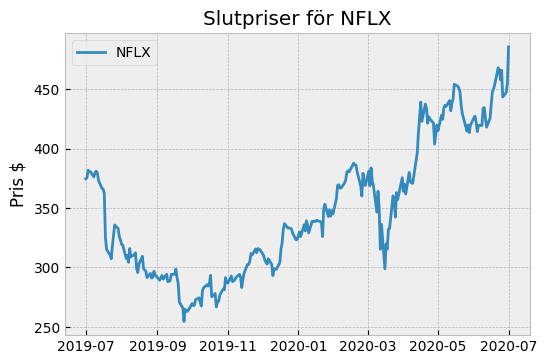

In [ ]:
plt.plot(data['Close'])              # Plotta kolumn 'Close' i data
plt.title("Slutpriser för NFLX")     # Diagramstitel
plt.ylabel("Pris $")                 # Y-axelns text
plt.legend(['NFLX'])        
plt.show()

In [ ]:
print(data['Close'].describe())

count    254.000000
mean     347.376023
std       56.660978
min      254.589996
25%      298.455002
50%      335.804993
75%      381.037491
max      485.640015
Name: Close, dtype: float64


## 3.2 Skattning för modell

### 3.2.1 $\sigma$ och $r$

Mitt sparkonto på danske-bank har $0\%$ avkastning, så kanske vi borde använda det. Men (!) eftersom vi arbetar med en amerikansk aktie tittar vi på amerikanska statsobligationer. I skrivandets stund har dessa en reporänta på $r=1,43\%$ om man låser fast sig på $30$ år.

In [ ]:
r = 0.0143 # procent

För att få ut $\sigma$ behöver vi titta på av den procentuella förändringen av priset varje dag. Vi antar att den är log-normalfördelad (vilket ofta stämmer). Volatiliteten blir standardavvikelsen på den samplad log-returns, ofta betäcknat som $u_i$.

$$\text{log-returns}=u_i = \text{ln}(\frac{S_i}{S_{i-1}}) \underbrace{\sim N(0, \sigma)}_{\text{Stämmer} \atop \text{förhoppningsvis}}$$

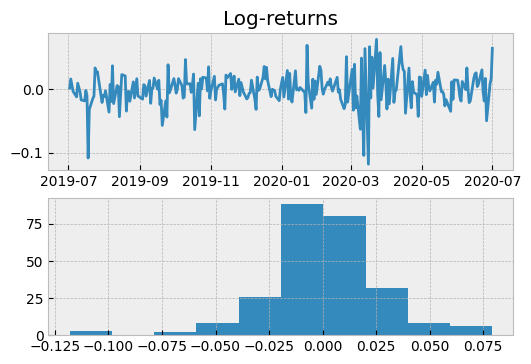

In [ ]:
# Skapar en ny kolumn i datasetet som heter 'log_returns'
data['log_returns'] = np.log(data['Close'].pct_change().dropna()+1) 
# Diagram
plt.subplot(2, 1, 1)
plt.plot((data['log_returns']))  # Titta på procentuell förändring
plt.title("Log-returns")
plt.subplot(2,1,2)
plt.hist(data['log_returns']) # Titta på fördelningen
plt.show()

Vet att $\sigma_\text{yr} = \sigma_\text{dag}\sqrt{T}$ som härstammar från random walk. Då amerikanska börsen har öppet 252 dagar om året använder vi det som vårt $T$. 

In [ ]:
# Räkna ut volitaliteten från formel för skattad standardavvikelse
stickprov = data.loc['2020-01-01':'2020-07-02']['log_returns']
sigma_dy = np.std(stickprov)
sigma_yr = sigma_dy*np.sqrt(252)
print("Daglig volitalitet: ", sigma_dy,"\nÅrlig volatilitet:", sigma_yr)

Daglig volitalitet:  0.03073711567446288 
Årlig volatilitet: 0.48793658456432487


Snyggt! En punktskattning på $\sigma$, som vi betecknar med en hatt: $\hat{\sigma}$. Detta för att visa att vi syftar på vår numeriska volitalitet.

**Reflektionsfrågor**

4. Bör vi ta med extrema och avvikande datapunkter i vår skattning? Varför/varför inte?  

5. Bör vi hantera datan för att få fram en bättre skattning på $\sigma$?

7. Vilken bias kommer det få på vårt punktsattning $\hat{\sigma}$?

### 3.2.2 Modellering av aktiekurs
Nu när vi har fått $\hat{\sigma}$ kan vi modellera aktiens utfall som en random walk.

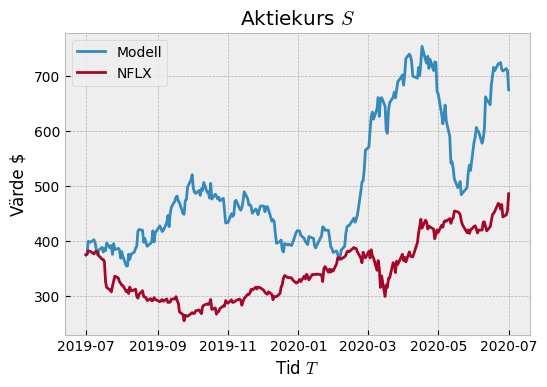

In [ ]:
# X är vår modellerade aktiekurs
X = [data['Close'][0]]        # matcha från start
# gå lika många steg som dagar i andra aktien
for i in range(len(data.index)-1):
    X.append(X[-1]*np.exp((np.random.normal(0,sigma_dy)))) # gå steg i walk 
# Diagram
plt.plot(data.index, X) # plot vår modellering
plt.plot(data['Close']) # plot NFLX
plt.title("Aktiekurs $S$")    # Titel
plt.xlabel("Tid $T$")         # namn x-axel
plt.ylabel("Värde $")         # namn y-axel
plt.legend(['Modell','NFLX']) # sätter in skylten (legend) med namn
plt.show()

### 3.2.3 Modellera bias $

För att försöka förstå hur bias och slumpen påverkar vår skattning kan vi göra en enkel modell på $\hat{\sigma}$.

$$\hat{\sigma}=\sigma+\text{bias}+\text{slump}$$

Sanningen är väl att det inte är en addativ modell som är den underliggande sanningen som spökar. Men om det vore så _enkelt_ kan vi se:

$$E[\hat{\sigma}]=E[\sigma+\text{bias}+\text{slump}]=\sigma+E[\text{bias}]+E[\text{slump}]$$

Så vårt mål är att få $E[\text{bias}]=E[\text{slump}]=0$ för att vår punktsakttning av $\sigma$ ska vara väntevärdesriktig. 

#### Reflektionsfrågor 

7. Kan du tänka dig en bättre modell av $\hat{\sigma}$?

## 3.3 Beräkna BS-priset

Vi minns att Black-Sholes kan ses som en funktion:
$$ BS_{S, K, T}(\sigma, r) = \text{pris} $$

In [ ]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    from scipy.stats import norm
    return (S*norm.cdf(d1, 0.0, 1.0)-K*np.exp(-r*T)*norm.cdf(d2, 0.0, 1.0))

$\sigma$ och $r$ punktskattades till $\hat{\sigma}$, $\hat{r}$. Senaste aktiepriset är givet till det senaste priset på marknaden. Men... hur ska vi bestämma strike $K$ och löptid $T$? I sig kan de vara vad som helst. 

Vi kan variera $T$ och $K$ för att se hur priset ändrar sig.

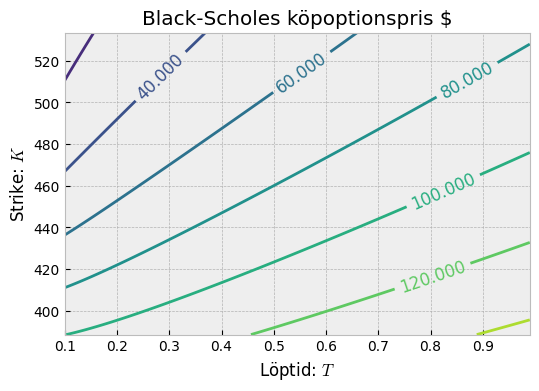

In [ ]:
S_ = data['Close'][-1]            # Dagens aktiepris
k = np.arange(0.8*S_, 1.1*S_, 1)  # x-axel
t = np.arange(0.1, 1, 0.01)       # y-axel
T_,K_  = np.meshgrid(t,k)        # skapa matris
Z = np.empty(K_.shape)            # skapa z-axel
# gå igenom matris och sätt z-axel till bs-pris
for i in range(Z.shape[0]):
  for j in range(Z.shape[1]):
    Z[i,j] = black_scholes(S_,K_[i,j],T_[i,j],r,sigma_yr)
# Lite mer avancerat plotningsteknik med matplotlib (men snygg graf, va?)
fig, ax = plt.subplots()
CS = ax.contour(T_,K_, Z)
ax.clabel(CS, inline=1, fontsize=12)
ax.set_title("Black-Scholes köpoptionspris $")
ax.set_ylabel("Strike: $K$")
ax.set_xlabel("Löptid: $T$")
plt.show()

Eftersom köpoptioner ger rätten att köpa optioner för priset $K$ om tiden $T$ så är det väldigt rimligt att det inte finns något värde att sätta $K$ till högre än dagens aktiepris $S_0$.

###  3.3.1 Marknadspriser
Det går att ladda hem marknadspriset för optioner med hjälp av `yfinance`, men det blir nog lättast om du går in på [Yahoo Finance NFLX Options](https://finance.yahoo.com/quote/NFLX/options/)  för att se hur de köps och säljs.

Avanza har också en bra [optionslista för svenska aktier](https://www.avanza.se/optioner-lista.html). 

Tänk på att sortera efter volym för att få upp de optioner som handlats mest, och således bör reflektera ett *riktigt* marknadspris bäst.

3 juli 2020 handlades `NFLX` för `476.89 USD`. Vi hitta en köpoptionen `NFLX Aug 2020 470.000 call` som 3 juli 2020 låg på `33.05 USD`. Optioner på Nasdaq går nästan alltid ut tredje fredagen i månaden som står i betäckningen, alltså 35 börsdagar från 3 juli. 


In [ ]:
S_NFLX = 476.89
K_NFLX = 470
T_NFLX = 35/252
print("Vårt beräknade pris:", 
      black_scholes(S_NFLX, K_NFLX, T_NFLX, r, sigma_yr), "USD")

Vårt beräknade pris: 38.31751335341335 USD


*Eh*...  det var ju inte samma som marknadspriset? Nä, och det kanske inte var helt väntat heller. Vi sa ju det innan: Modeller är fel! Något vi behöver är att titta på konfidensintervall på vårat $\hat{\sigma}$, men innan vi gör det ska vi besvara en vettig fråga som har dykt upp. Nu när vi bevisligen har fått ett annat $\sigma$: Vad är marknadens skattning av $\sigma$?

### 3.3.2 Implicerad Volatilitet
Vi kan räkna ut den implicerade volatiliteten till det $\sigma$ som matchar marknadspriset i vår Black-Scholes-formel. Vi nyttjar Netwon-Rhapson som kan hittar rötter!

In [ ]:
from scipy.optimize import newton
# Skriv om BS så vi letar efter ett nollställe
objFunction = lambda x : black_scholes(S_NFLX, K_NFLX, T_NFLX, r, x)-33.05
sigma_imp = newton(objFunction, sigma_yr)
print("Marknadens implicerade volatitlitet: ", sigma_imp)

Marknadens implicerade volatitlitet:  0.4123939711920358


Marknaden tror alltså på en högre risk i framtiden än den som var utfallen från förra året.

#### Reflektionsfrågor:

8. Varför tror du $\hat{\sigma}_{imp}<\hat{\sigma}_{hist}$? Gäller det alltid?

9. Hur kan vi bestämma ett konfidensintervall på $\hat{\sigma}_{imp}$?

10. Varför behövs en kvanitativ analys av $\hat{\sigma}$ när vi kan ta den implicerade volatiliteten rakt av? 



## 3.4 Säkerhet på $\hat{\sigma}$
*Jaja, ta det lugnt!* Vi hör ditt skrik och panik. Hur säkra är vi på $\hat{\sigma}_\text{hist}$? Vi saknar ju helt konfidensintervall! Är det någonting vi är säkra på är det att saker är osäkra, och det bör vi kvantifiera.

Hittills har vi punktskattat $\sigma$ genom att anta att den är värdet på dagligavkastningen är normalfördeled: $\text{ln} \frac{S_t}{S_{t-1}} \sim N(0,\sigma)$ 






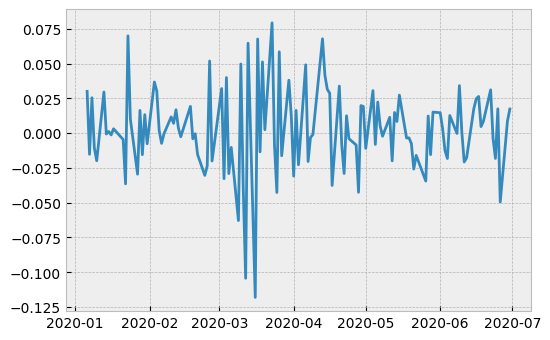

In [ ]:
stickprov = data.loc['2020-01-04':'2020-06-30']['log_returns']
plt.plot(stickprov) 
plt.show()

### 3.4.1 Shapiro-Wilks test
För att se om en population följer en normalfördelning kan vi använda oss av Shapiro-Wilks test.

$$H_0: \text{log-returns är normalfördelad}$$

Testet finns förprogrammerat i Python-biblioteket Scipy: [dokumentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html).

In [ ]:
from scipy import stats
test_statistic, p_value = stats.shapiro(stickprov)
print("P-value: ",p_value)

P-value:  0.0019483135547488928


Vi kan alltså inte förkasta nollhyptosesen! Vi håller fast vid vårt antagande att datan är normalfördelad.

### 3.4.2 Konfidensintervall på $\hat{\sigma}$

Från *Sannolikhetsteori och statistikteori med tillämpning*, kursboken i *SF1918 Sannolikhet och statistik*, finner vi konfidensintervallet för standardavvikelsen i **Sats 12.2** 

$$ I_\sigma = (\sqrt{f/\chi_{\alpha / 2}(f)} \cdot \hat{\sigma}, \sqrt{f/\chi_{1-\alpha / 2}(f)} \cdot \hat{\sigma}) $$

In [ ]:
df = len(stickprov)-1
alpha = 0.05
sig_yr = np.std(stickprov)*np.sqrt(252)
I = [np.sqrt(df/stats.chi2.isf(alpha/2,df))*sig_yr,
     np.sqrt(df/stats.chi2.isf(1-alpha/2,df))*sig_yr]
print("Under I-05%:\t", I[0],"\nEstimerat Sigma:", sig_yr, "\nÖvre I-95%:\t",I[1])

Under I-05%:	 0.4308219707249858 
Estimerat Sigma: 0.4847650114718144 
Övre I-95%:	 0.554272129734337


### 3.4.3 Effekt på BS


In [ ]:
print("Undre 5%:\t",black_scholes(S_NFLX, K_NFLX, T_NFLX, r, I[0]), "USD")
print("Estimerad BS:\t", black_scholes(S_NFLX, K_NFLX, T_NFLX, r, sig_yr), "USD")
print("Övre 95%:\t", black_scholes(S_NFLX, K_NFLX, T_NFLX, r, I[1]), "USD")

Undre 5%:	 34.334698273569586 USD
Estimerad BS:	 38.096329340557276 USD
Övre 95%:	 42.94329688809168 USD


Nämen se så fint!